In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import SymLogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import rioxarray as rxr
from scipy.interpolate import RegularGridInterpolator
from shapely.geometry import Point
import geopandas as gpd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import griddata
from osgeo import gdal
import rasterio
import os
from netCDF4 import Dataset

PROJ: proj_create_from_database: Cannot find proj.db


## Converting into .nc files


## Free-air anomaly

In [2]:
grav_file = r"grav_LA.txt"
curv_file = r"curv_LA.txt"

grav_df = pd.read_csv(grav_file, sep="\t", header=None, names=["lon", "lat", "faa"])
curv_df = pd.read_csv(curv_file, sep="\t", header=None, names=["lon", "lat", "curv"])
curv_df["curv_mGal_per_km"] = curv_df["curv"] * 0.1

#print(grav_df)
#print(np.min(curv_df))
#print(np.max(curv_df))

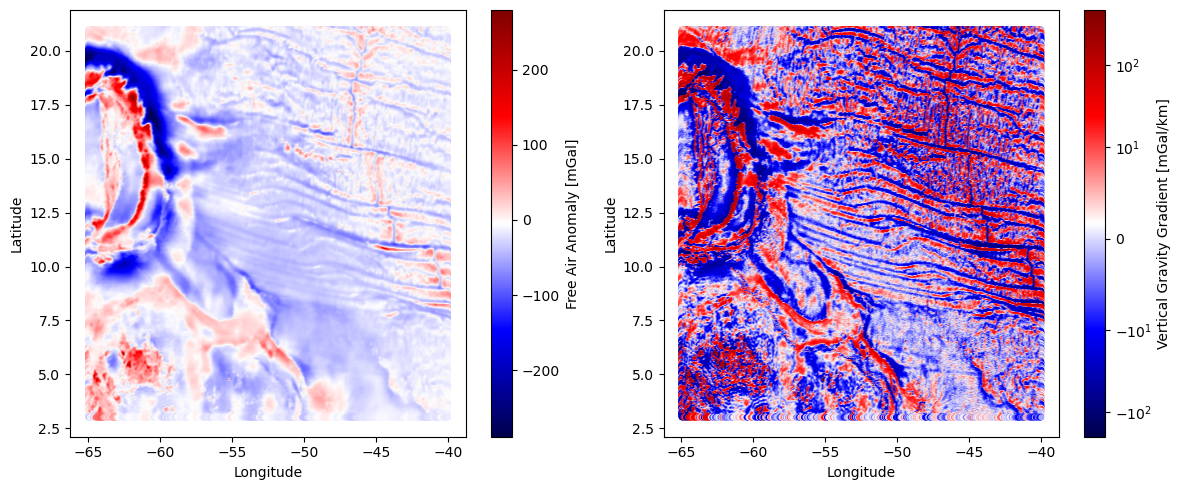

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

proj = ccrs.PlateCarree()

sc1 = axes[0].scatter(grav_df["lon"], grav_df["lat"], c=grav_df["faa"], cmap="seismic", s=10)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
plt.colorbar(sc1, ax=axes[0], label="Free Air Anomaly [mGal]")

norm = SymLogNorm(
    linthresh=10,   
    linscale=1.0,
    vmin=-200,
    vmax=470,
    base=10  
)

sc2 = axes[1].scatter(curv_df["lon"], curv_df["lat"], c=curv_df["curv"], cmap="seismic", s=10, norm=norm)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.colorbar(sc2, ax=axes[1], label="Vertical Gravity Gradient [mGal/km]")

plt.tight_layout()
plt.show()


In [4]:
# proj = ccrs.PlateCarree()

# fig, axs = plt.subplots(ncols=2, figsize=(16, 6), subplot_kw={'projection': proj})

# sc1 = axs[0].scatter(
#     grav_df["lon"], grav_df["lat"], c=grav_df["faa"], cmap="viridis", s=10, transform=proj
# )
# axs[0].set_title("Free Air Anomaly [mGal]")
# axs[0].set_xlabel("Longitude")
# axs[0].set_ylabel("Latitude")
# axs[0].add_feature(cfeature.COASTLINE)
# axs[0].add_feature(cfeature.LAND, facecolor='lightgray')
# axs[0].add_feature(cfeature.BORDERS, linestyle=':')

# cbar1 = plt.colorbar(sc1, ax=axs[0], orientation="vertical", label="mGal")

# sc2 = axs[1].scatter(
#     curv_df["lon"], curv_df["lat"], c=curv_df["curv"], cmap="coolwarm", s=10, transform=proj
# )
# axs[1].set_title("Vertical Gravity Gradient [mGal/km]")
# axs[1].set_xlabel("Longitude")
# axs[1].set_ylabel("Latitude")
# axs[1].add_feature(cfeature.COASTLINE)
# axs[1].add_feature(cfeature.LAND, facecolor='lightgray')
# axs[1].add_feature(cfeature.BORDERS, linestyle=':')

# cbar2 = plt.colorbar(sc2, ax=axs[1], orientation="vertical", label="Eotvos")
# # 
# plt.tight_layout()
# plt.show()

## Merging the gebco and gravity data


In [5]:
gebco = xr.open_dataset("C:/Users/Inni/Desktop/Grav/gebco_2024.nc")
print(gebco)       

<xarray.Dataset> Size: 205MB
Dimensions:    (lat: 7130, lon: 14385)
Coordinates:
  * lat        (lat) float64 57kB -3.769 -3.765 -3.76 ... 25.93 25.93 25.94
  * lon        (lon) float64 115kB -93.25 -93.24 -93.24 ... -33.32 -33.32 -33.31
Data variables:
    elevation  (lat, lon) int16 205MB ...
Attributes: (12/36)
    title:                           The GEBCO_2024 Grid - a continuous terra...
    summary:                         The GEBCO_2024 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/1c44ce99-0a0d-5f4f-e063-708...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/1c44ce99-0a0d-5f4f-e063-708...
   

In [6]:
gebco = xr.open_dataset("gebco_2024.nc")
grav = xr.open_dataset("grav_LA.nc")
curv = xr.open_dataset("curv_LA.nc")

In [7]:
print(gebco.dims)
print(grav.dims)
print(curv.dims)

print(gebco.coords)
print(grav.coords)
print(curv.coords)

FrozenMappingWarningOnValuesAccess({'lat': 7130, 'lon': 14385})
FrozenMappingWarningOnValuesAccess({'lon': 1500, 'lat': 1080})
FrozenMappingWarningOnValuesAccess({'lon': 1500, 'lat': 1080})
Coordinates:
  * lat      (lat) float64 57kB -3.769 -3.765 -3.76 -3.756 ... 25.93 25.93 25.94
  * lon      (lon) float64 115kB -93.25 -93.24 -93.24 ... -33.32 -33.32 -33.31
Coordinates:
  * lon      (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.04 -40.02 -40.01
  * lat      (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99
Coordinates:
  * lon      (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.04 -40.02 -40.01
  * lat      (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99


In [8]:
# Different resolution and coordinates = interpolating the data, let's try nearest - I'm dowsampling gebco not to add any artefacts
lat_grav = grav.lat
lon_grav = grav.lon
gebco_interp = gebco.interp(lat=lat_grav, lon=lon_grav, method="linear")

In [9]:
print(gebco_interp.dims)
print(grav.dims)
print(curv.dims)

print(gebco_interp.coords)
print(grav.coords)
print(curv.coords)

# the files have now the same grid, we can merge them

FrozenMappingWarningOnValuesAccess({'lat': 1080, 'lon': 1500})
FrozenMappingWarningOnValuesAccess({'lon': 1500, 'lat': 1080})
FrozenMappingWarningOnValuesAccess({'lon': 1500, 'lat': 1080})
Coordinates:
  * lat      (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99
  * lon      (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.04 -40.02 -40.01
Coordinates:
  * lon      (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.04 -40.02 -40.01
  * lat      (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99
Coordinates:
  * lon      (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.04 -40.02 -40.01
  * lat      (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99


In [10]:
print(gebco_interp.data_vars)
print(grav.data_vars)
print(curv.data_vars)

Data variables:
    elevation  (lat, lon) float64 13MB 162.3 161.5 ... -5.289e+03 -5.31e+03
Data variables:
    z        (lat, lon) float32 6MB ...
Data variables:
    z        (lat, lon) float32 6MB ...


In [11]:
merged_grav = xr.Dataset({
    "elevation": gebco_interp["elevation"], 
    "gravity": grav["z"]
})

merged_curv = xr.Dataset({
    "elevation": gebco_interp["elevation"],
    "curvature": curv["z"]
})

In [12]:
merged_grav.to_netcdf("merged_gravity.nc")
merged_curv.to_netcdf("merged_curv.nc")


## Adding Ifremer bathy data

In [13]:
mbes = rxr.open_rasterio('C:/Users/Inni/Desktop/Grav/Synthese_ArcAntillais_1_16min_BATHY.tif')

print(mbes.rio.crs)
print(mbes)

EPSG:4326
<xarray.DataArray 'elevation' (band: 1, y: 11521, x: 9600)> Size: 442MB
[110601600 values with dtype=float32]
Coordinates:
  * band     (band) int32 4B 1
  * x        (x) float64 77kB -65.0 -65.0 -65.0 -65.0 ... -55.0 -55.0 -55.0
  * y        (y) float64 92kB 21.0 21.0 21.0 21.0 ... 9.004 9.003 9.002 9.001
    crs      int32 4B 0
Attributes: (12/39)
    lat#axis:                 Y
    lat#long_name:            latitude
    lat#sdn_parameter_name:   Latitude north
    lat#sdn_parameter_urn:    SDN:P01::ALATZZ01
    lat#sdn_uom_name:         Degrees north
    lat#sdn_uom_urn:          SDN:P06::DEGN
    ...                       ...
    sdn_uom_name:             Metres
    sdn_uom_urn:              SDN:P06::ULAA
    units:                    m
    _FillValue:               -99999.0
    scale_factor:             1.0
    add_offset:               0.0


In [14]:
mbes = mbes.squeeze("band", drop=True) 
mbes = mbes.rename({"x": "lon", "y": "lat"})
mbes_interp = mbes.interp(lat=gebco_interp.lat, lon=gebco_interp.lon, method="linear")

In [15]:
gebco_bathy = gebco_interp["elevation"].rename("gebco_bathy")
mbes_bathy = mbes_interp.rename("mbes_bathy")

merged_bathy = xr.merge([
    gebco_bathy.to_dataset(),
    mbes_bathy.to_dataset()
])

In [16]:
merged_bathy.to_netcdf("merged_bathy.nc")

<xarray.Dataset> Size: 26MB
Dimensions:      (lat: 1080, lon: 1500)
Coordinates:
  * lat          (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99
  * lon          (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.02 -40.01
    crs          int32 4B 0
Data variables:
    gebco_bathy  (lat, lon) float64 13MB 162.3 161.5 ... -5.289e+03 -5.31e+03
    mbes_bathy   (lat, lon) float64 13MB nan nan nan nan nan ... nan nan nan nan


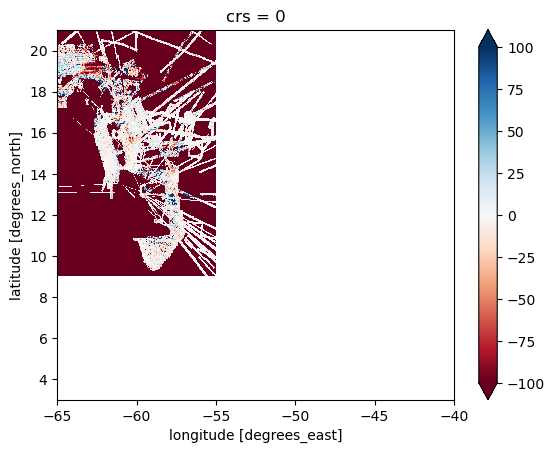

In [17]:
print(merged_bathy)
bathy_diff = merged_bathy["mbes_bathy"] - merged_bathy["gebco_bathy"]
bathy_diff.plot(cmap="RdBu", vmin=-100, vmax=100)

## Shipborne data vs satellite data


In [18]:
file_paths = ["E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti1.xyz",
            "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti2.xyz",
            "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti3.xyz"]


no_data_value = -2147483648.00

def load_gravity_file(file_path):
    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=22,  
        names=["date", "time", "lat", "lon", "grav", "FAA"],
        engine="python"
    )
    df = df[df["FAA"] != no_data_value]
    return df

dfs = [load_gravity_file(path) for path in file_paths]
df_all = pd.concat(dfs, ignore_index=True)


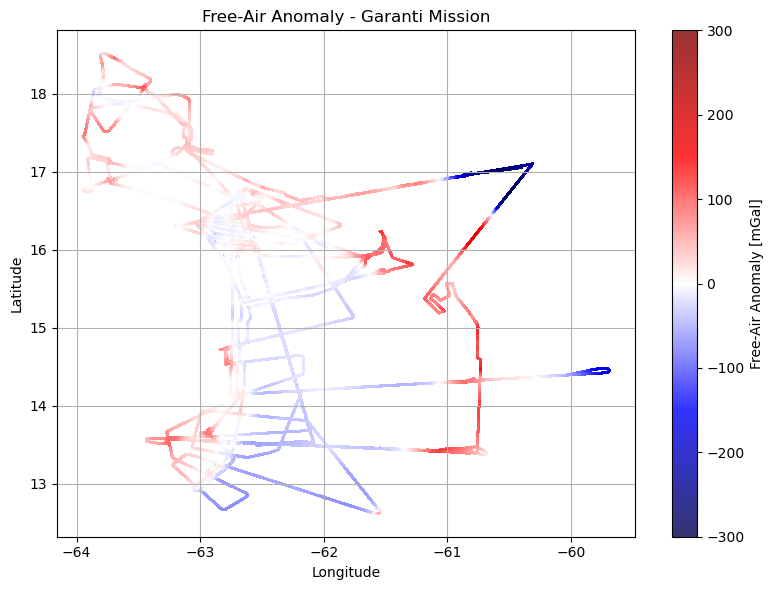

In [19]:
#abs_max = np.max(np.abs(df_all["FAA"]))
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_all["lon"], df_all["lat"], c=df_all["FAA"],
                 cmap="seismic", s=1, marker=".", alpha=0.8, vmin=-300, vmax=300)

plt.colorbar(sc, label="Free-Air Anomaly [mGal]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Free-Air Anomaly - Garanti Mission")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print(np.min(df_all["FAA"]))
print(np.max(df_all["FAA"]))

-281.72
183.9


In [21]:
file_paths = ["E:/Ania/Grav/Python_Scripts/Antithesis1/Grav/antithesis_grav_vrai.dat"]


no_data_value = -2147483648.00

def load_gravity_file(file_path):
    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=17,  
        names=["date", "time", "lat", "lon", "FAA"],
        engine="python"
    )
    df = df[df["FAA"] != no_data_value]
    return df

dfs = [load_gravity_file(path) for path in file_paths]
df_all = pd.concat(dfs, ignore_index=True)

In [22]:
print(dfs)

[             date          time        lat        lon     FAA
0        24/12/13  07:58:00.818  16.232971 -61.546371  105.88
1        24/12/13  07:58:01.819  16.232971 -61.546371  105.88
2        24/12/13  07:58:02.819  16.232971 -61.546371  105.88
3        24/12/13  07:58:03.818  16.232971 -61.546371  105.88
4        24/12/13  07:58:04.819  16.232971 -61.546372  105.88
...           ...           ...        ...        ...     ...
1229446  07/01/14  16:27:59.721  16.028459 -61.191997   82.99
1229447  07/01/14  16:28:00.723  16.028472 -61.192020   82.96
1229448  07/01/14  16:28:01.721  16.028485 -61.192041   82.93
1229449  07/01/14  16:28:02.721  16.028498 -61.192063   82.90
1229450  07/01/14  16:28:03.722  16.028511 -61.192087   82.87

[1229451 rows x 5 columns]]


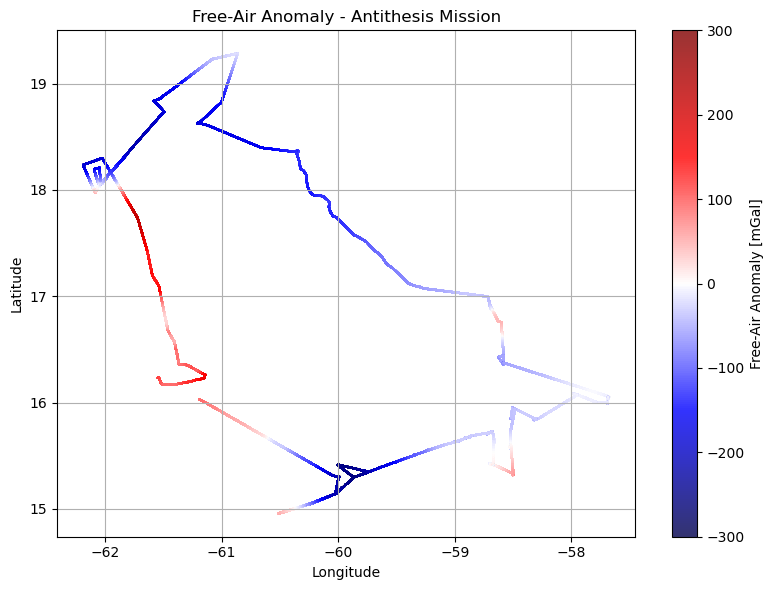

In [23]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_all["lon"], df_all["lat"], c=df_all["FAA"],
                 cmap="seismic", s=1, marker=".", alpha=0.8, vmin=-300, vmax=300 )

plt.colorbar(sc, label="Free-Air Anomaly [mGal]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Free-Air Anomaly - Antithesis Mission")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
garanti_paths = [
    "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti1.xyz",
    "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti2.xyz",
    "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti3.xyz"
]

def load_gravity_file(file_path, skiprows=22):
    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=skiprows,
        names=["date", "time", "lat", "lon", "grav", "FAA"],
        engine="python"
    )
    df = df[df["FAA"] != -2147483648.00]
    return df

df_garanti = pd.concat([load_gravity_file(p) for p in garanti_paths], ignore_index=True)
df_garanti["mission"] = "Garanti"

antithesis_path = "E:/Ania/Grav/Python_Scripts/Antithesis1/Grav/antithesis_grav_vrai.dat"

def load_antithesis(file_path, skiprows=17):
    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=skiprows,
        names=["date", "time", "lat", "lon", "FAA"],
        engine="python"
    )
    df = df[df["FAA"] != -2147483648.00]
    df["mission"] = "Antithesis"
    return df

df_antithesis = load_antithesis(antithesis_path)

combined_df = pd.concat([df_garanti, df_antithesis], ignore_index=True)



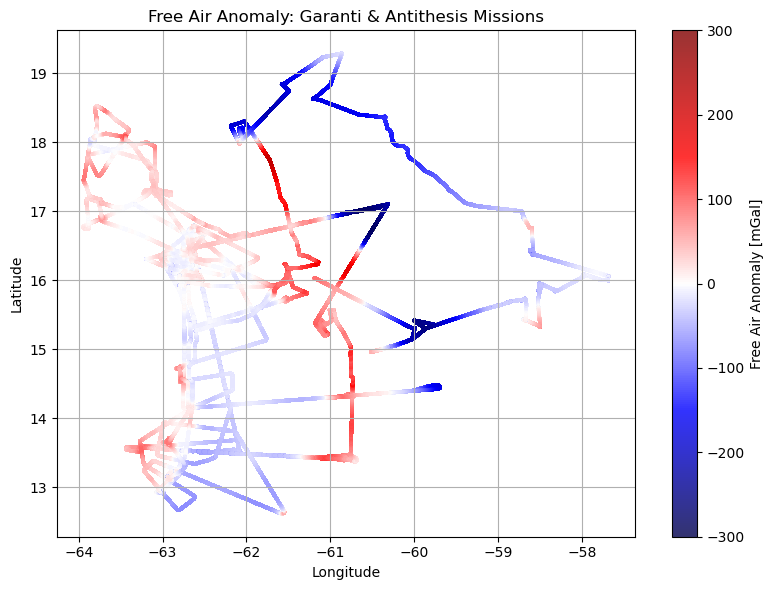

In [25]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    combined_df["lon"],
    combined_df["lat"],
    c=combined_df["FAA"],
    cmap="seismic",
    s=2,
    alpha=0.8, vmin=-300, vmax=300
)
plt.colorbar(scatter, label="Free Air Anomaly [mGal]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Free Air Anomaly: Garanti & Antithesis Missions")

plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
## Extracting the satelite data at the shipborne locations

sat_path = "E:/Ania/Grav/Python_Scripts/SWOT/grav_LA.nc" 

ds = xr.open_dataset(sat_path)
print(ds)  

lon = ds["lon"].values
lat = ds["lat"].values
sat_grav = ds["z"].values  

interpolator = RegularGridInterpolator(
    (lat, lon),
    sat_grav,
    bounds_error=False,
    fill_value=np.nan
)

points = df_garanti[["lat", "lon"]].values
df_garanti["satellite_gravity"] = interpolator(points)

df_garanti.to_csv("garanti_with_satellite_gravity.csv", index=False)

print(sat_path)

<xarray.Dataset> Size: 7MB
Dimensions:  (lon: 1500, lat: 1080)
Coordinates:
  * lon      (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.04 -40.02 -40.01
  * lat      (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99
Data variables:
    z        (lat, lon) float32 6MB ...
Attributes:
    Conventions:  CF-1.7
    title:        Produced by grdcut
    history:      gmt grdcut grav_SWOT_03.nc -R-65/-40/3/21 -Ggrav_LA.nc
    description:  
    GMT_version:  6.5.0 [64-bit]
    node_offset:  1
E:/Ania/Grav/Python_Scripts/SWOT/grav_LA.nc


In [27]:
print(df_garanti[["lat", "lon", "FAA", "satellite_gravity"]])


               lat        lon     FAA  satellite_gravity
0        16.234451 -61.537077  109.60         118.443490
1        16.234451 -61.537077  109.61         118.443490
2        16.234451 -61.537077  109.61         118.443490
3        16.234451 -61.537077  109.61         118.443490
4        16.234451 -61.537077  109.62         118.443490
...            ...        ...     ...                ...
3788551  16.234441 -61.537061  115.70         118.441349
3788552  16.234441 -61.537061  115.70         118.441349
3788553  16.234441 -61.537061  115.70         118.441349
3788554  16.234441 -61.537061  115.70         118.441349
3788555  16.234441 -61.537061  115.70         118.441349

[3788556 rows x 4 columns]


In [28]:
points = df_antithesis[["lat", "lon"]].values
df_antithesis["satellite_gravity"] = interpolator(points)

df_antithesis.to_csv("antithesis_with_satellite_gravity.csv", index=False)

In [29]:
print(df_antithesis[["lat", "lon", "FAA", "satellite_gravity"]])

               lat        lon     FAA  satellite_gravity
0        16.232971 -61.546371  105.88         117.869083
1        16.232971 -61.546371  105.88         117.869083
2        16.232971 -61.546371  105.88         117.869083
3        16.232971 -61.546371  105.88         117.869083
4        16.232971 -61.546372  105.88         117.869057
...            ...        ...     ...                ...
1229446  16.028459 -61.191997   82.99          86.804885
1229447  16.028472 -61.192020   82.96          86.802563
1229448  16.028485 -61.192041   82.93          86.799776
1229449  16.028498 -61.192063   82.90          86.797218
1229450  16.028511 -61.192087   82.87          86.795118

[1229451 rows x 4 columns]


In [30]:
## Reprojecting to UTM 20N

df = pd.read_csv("antithesis_with_satellite_gravity.csv") 

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"  # WGS84
)

gdf_utm = gdf.to_crs("EPSG:32620")

gdf_utm["x"] = gdf_utm.geometry.x
gdf_utm["y"] = gdf_utm.geometry.y

antithesis_projected = gdf_utm.drop(columns="geometry")



In [31]:
print(antithesis_projected)

             date          time        lat        lon     FAA     mission  \
0        24/12/13  07:58:00.818  16.232971 -61.546371  105.88  Antithesis   
1        24/12/13  07:58:01.819  16.232971 -61.546371  105.88  Antithesis   
2        24/12/13  07:58:02.819  16.232971 -61.546371  105.88  Antithesis   
3        24/12/13  07:58:03.818  16.232971 -61.546371  105.88  Antithesis   
4        24/12/13  07:58:04.819  16.232971 -61.546372  105.88  Antithesis   
...           ...           ...        ...        ...     ...         ...   
1229446  07/01/14  16:27:59.721  16.028459 -61.191997   82.99  Antithesis   
1229447  07/01/14  16:28:00.723  16.028472 -61.192020   82.96  Antithesis   
1229448  07/01/14  16:28:01.721  16.028485 -61.192041   82.93  Antithesis   
1229449  07/01/14  16:28:02.721  16.028498 -61.192063   82.90  Antithesis   
1229450  07/01/14  16:28:03.722  16.028511 -61.192087   82.87  Antithesis   

         satellite_gravity              x             y  
0               1

In [32]:
df = pd.read_csv("garanti_with_satellite_gravity.csv") 

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"  # WGS84
)

gdf_utm = gdf.to_crs("EPSG:32620")

gdf_utm["x"] = gdf_utm.geometry.x
gdf_utm["y"] = gdf_utm.geometry.y

garanti_projected = gdf_utm.drop(columns="geometry")

In [33]:
print(garanti_projected)

             date          time        lat        lon     grav     FAA  \
0        07/05/17  11:56:54.505  16.234451 -61.537077 -2397.42  109.60   
1        07/05/17  11:56:55.504  16.234451 -61.537077 -2397.42  109.61   
2        07/05/17  11:56:56.525  16.234451 -61.537077 -2397.42  109.61   
3        07/05/17  11:56:57.525  16.234451 -61.537077 -2397.42  109.61   
4        07/05/17  11:56:58.515  16.234451 -61.537077 -2397.41  109.62   
...           ...           ...        ...        ...      ...     ...   
3788551  24/06/17  22:06:15.652  16.234441 -61.537061 -2396.10  115.70   
3788552  24/06/17  22:06:16.631  16.234441 -61.537061 -2396.10  115.70   
3788553  24/06/17  22:06:17.652  16.234441 -61.537061 -2396.10  115.70   
3788554  24/06/17  22:06:18.651  16.234441 -61.537061 -2396.10  115.70   
3788555  24/06/17  22:06:19.652  16.234441 -61.537061 -2396.10  115.70   

         mission  satellite_gravity              x             y  
0        Garanti         118.443490  656351.

In [34]:
combined_projected = pd.concat([garanti_projected, antithesis_projected], ignore_index=True)

In [35]:
print(combined_projected)

             date          time        lat        lon     grav     FAA  \
0        07/05/17  11:56:54.505  16.234451 -61.537077 -2397.42  109.60   
1        07/05/17  11:56:55.504  16.234451 -61.537077 -2397.42  109.61   
2        07/05/17  11:56:56.525  16.234451 -61.537077 -2397.42  109.61   
3        07/05/17  11:56:57.525  16.234451 -61.537077 -2397.42  109.61   
4        07/05/17  11:56:58.515  16.234451 -61.537077 -2397.41  109.62   
...           ...           ...        ...        ...      ...     ...   
5018002  07/01/14  16:27:59.721  16.028459 -61.191997      NaN   82.99   
5018003  07/01/14  16:28:00.723  16.028472 -61.192020      NaN   82.96   
5018004  07/01/14  16:28:01.721  16.028485 -61.192041      NaN   82.93   
5018005  07/01/14  16:28:02.721  16.028498 -61.192063      NaN   82.90   
5018006  07/01/14  16:28:03.722  16.028511 -61.192087      NaN   82.87   

            mission  satellite_gravity              x             y  
0           Garanti         118.443490  6

### Stats

In [36]:
garanti_projected['difference'] = garanti_projected['FAA'] - garanti_projected['satellite_gravity']
stats_garanti = garanti_projected['difference'].describe()
print("Garanti: \n", stats_garanti)

antithesis_projected['difference'] = antithesis_projected['FAA'] - antithesis_projected['satellite_gravity']
stats_antithesis = antithesis_projected['difference'].describe()
print("Antithesis: \n",  stats_antithesis)

Garanti: 
 count    3.788556e+06
mean     1.995588e+00
std      3.706607e+00
min     -5.845299e+01
25%      5.249648e-05
50%      1.812993e+00
75%      3.764985e+00
max      3.243665e+01
Name: difference, dtype: float64
Antithesis: 
 count    1.229451e+06
mean    -3.711089e+00
std      3.496988e+00
min     -4.073705e+01
25%     -4.220563e+00
50%     -3.000846e+00
75%     -2.015286e+00
max      2.989861e+01
Name: difference, dtype: float64


In [37]:
combined_projected['difference'] = combined_projected['FAA'] - combined_projected['satellite_gravity']
stats_combined = combined_projected['difference'].describe()
print("Combined: \n", stats_combined)

Combined: 
 count    5.018007e+06
mean     5.974076e-01
std      4.403751e+00
min     -5.845299e+01
25%     -1.905865e+00
50%      7.319063e-01
75%      3.069736e+00
max      3.243665e+01
Name: difference, dtype: float64


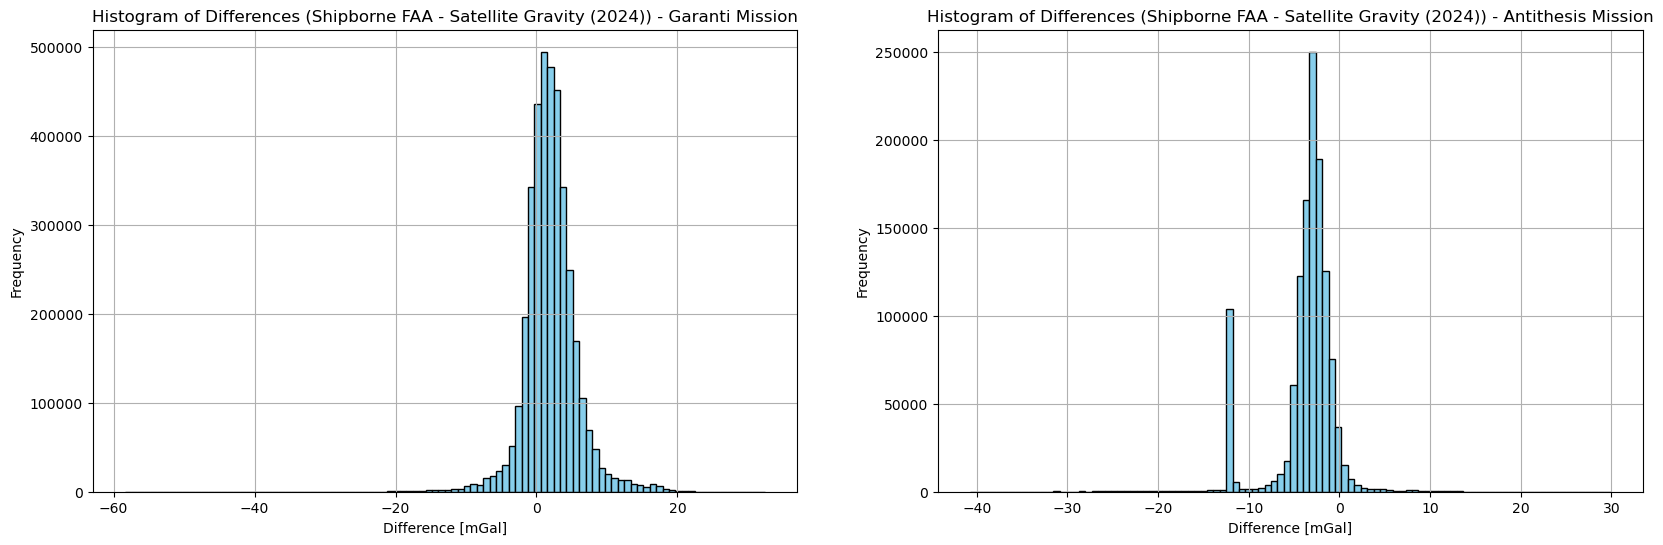

In [38]:
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
plt.hist(garanti_projected['difference'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Differences (Shipborne FAA - Satellite Gravity (2024)) - Garanti Mission')
plt.xlabel('Difference [mGal]')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(antithesis_projected['difference'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Differences (Shipborne FAA - Satellite Gravity (2024)) - Antithesis Mission')
plt.xlabel('Difference [mGal]')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

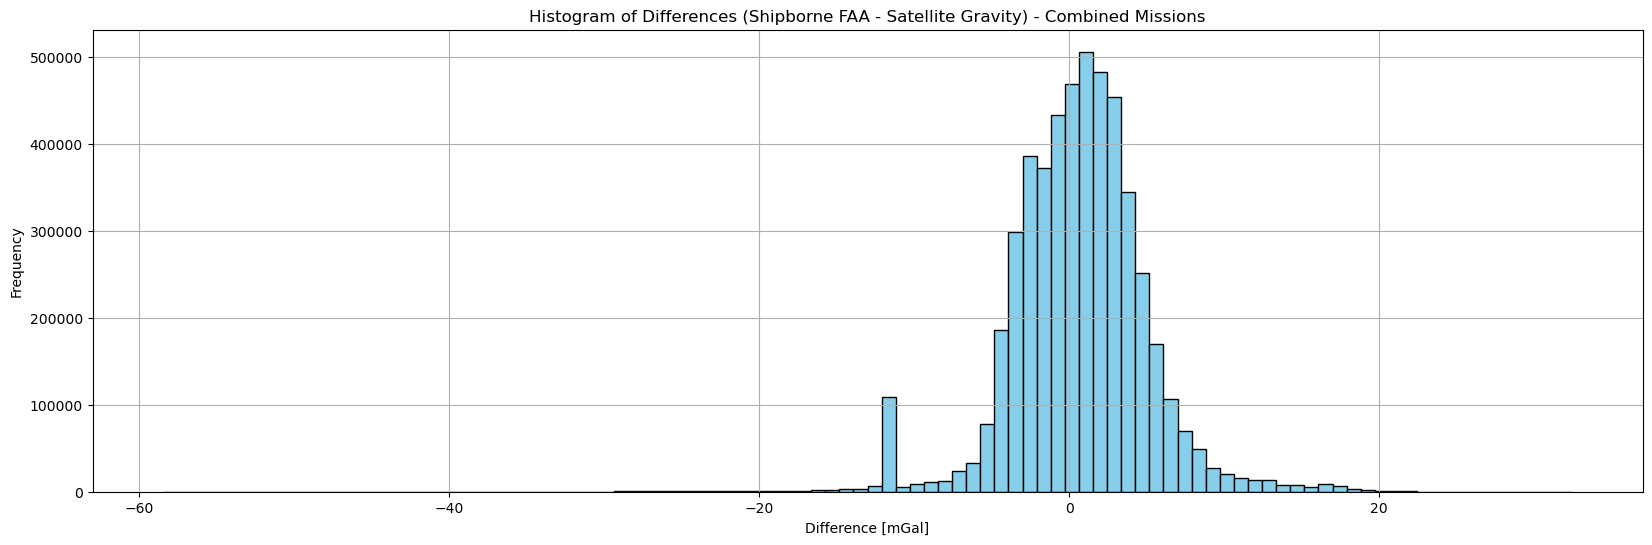

In [39]:
plt.figure(figsize=(20,6))
plt.hist(combined_projected['difference'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Differences (Shipborne FAA - Satellite Gravity) - Combined Missions')
plt.xlabel('Difference [mGal]')
plt.ylabel('Frequency')
plt.grid(True)

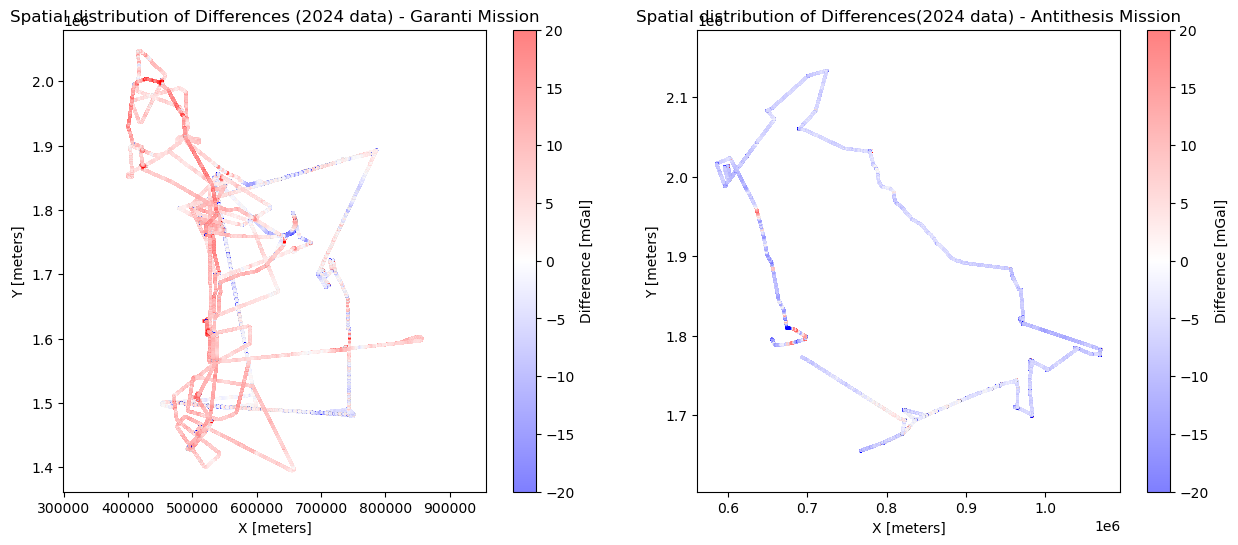

In [40]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sc = plt.scatter(garanti_projected['x'], garanti_projected['y'], c=garanti_projected['difference'], cmap='bwr', s=1, alpha=0.5, vmin=-20, vmax=20)
plt.colorbar(sc, label='Difference [mGal]')
plt.title('Spatial distribution of Differences (2024 data) - Garanti Mission')
plt.xlabel('X [meters]')
plt.ylabel('Y [meters]')
plt.axis('equal')

plt.subplot(1,2,2)
sc = plt.scatter(antithesis_projected['x'], antithesis_projected['y'], c=antithesis_projected['difference'], cmap='bwr', s=1, alpha=0.5, vmin=-20, vmax=20)
plt.colorbar(sc, label='Difference [mGal]')
plt.title('Spatial distribution of Differences(2024 data) - Antithesis Mission')
plt.xlabel('X [meters]')
plt.ylabel('Y [meters]')
plt.axis('equal')
plt.show()

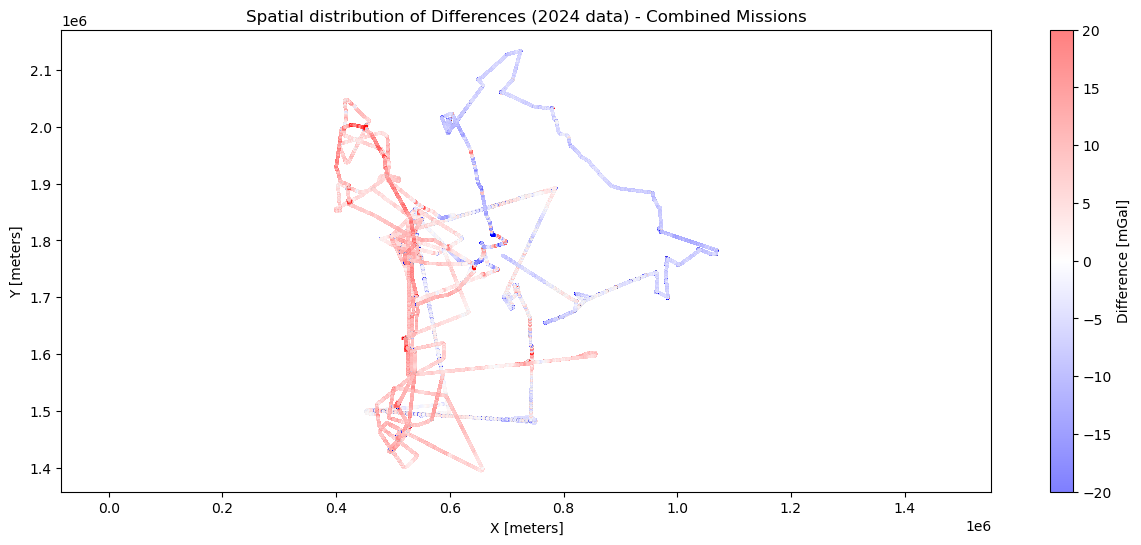

In [41]:
plt.figure(figsize=(15,6))
sc = plt.scatter(combined_projected['x'], combined_projected['y'], c=combined_projected['difference'], cmap='bwr', s=1, alpha=0.5, vmin=-20, vmax=20)
plt.colorbar(sc, label='Difference [mGal]')
plt.title('Spatial distribution of Differences (2024 data) - Combined Missions')
plt.xlabel('X [meters]')
plt.ylabel('Y [meters]')
plt.axis('equal')
plt.show()

In [42]:
num_negative = (garanti_projected['difference'] < 0).sum()
print(f"Number of negative differencesfor Garanti: {num_negative}")

min_diff_row = garanti_projected.loc[garanti_projected['difference'].idxmin()]
print("Row with the maximum negative difference for Garanti:")
print(min_diff_row)

print("----")

num_negative = (antithesis_projected['difference'] < 0).sum()
print(f"Number of negative differences for Antithesis: {num_negative}")

min_diff_row = antithesis_projected.loc[antithesis_projected['difference'].idxmin()]
print("Row with the maximum negative difference for Antithesis:")
print(min_diff_row)

Number of negative differencesfor Garanti: 947112
Row with the maximum negative difference for Garanti:
date                      14/05/17
time                  08:12:53.441
lat                      13.516376
lon                     -62.506958
grav                      -2761.27
FAA                        -108.64
mission                    Garanti
satellite_gravity       -50.187009
x                    553354.038942
y                    1494294.60113
difference              -58.452991
Name: 590313, dtype: object
----
Number of negative differences for Antithesis: 1181882
Row with the maximum negative difference for Antithesis:
date                       02/01/14
time                   01:40:47.516
lat                       15.846825
lon                      -58.518374
FAA                          -73.66
mission                  Antithesis
satellite_gravity         -32.92295
x                     980279.436212
y                    1757128.858458
difference                -40.73705
Name: 

In [43]:
num_negative = (combined_projected['difference'] < 0).sum()
print(f"Number of negative differencesfor both missions: {num_negative}")

min_diff_row = combined_projected.loc[combined_projected['difference'].idxmin()]
print("Row with the maximum negative difference for both missions:")
print(min_diff_row)

Number of negative differencesfor both missions: 2128994
Row with the maximum negative difference for both missions:
date                      14/05/17
time                  08:12:53.441
lat                      13.516376
lon                     -62.506958
grav                      -2761.27
FAA                        -108.64
mission                    Garanti
satellite_gravity       -50.187009
x                    553354.038942
y                    1494294.60113
difference              -58.452991
Name: 590313, dtype: object


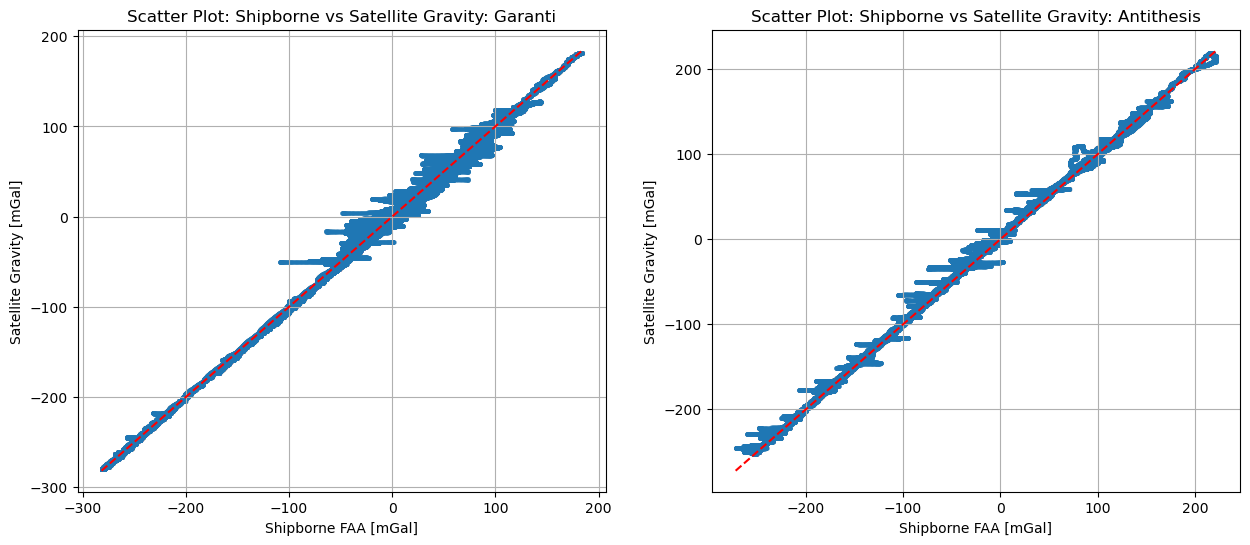

In [44]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(garanti_projected['FAA'], garanti_projected['satellite_gravity'], alpha=0.3, s=5)
plt.plot([garanti_projected['FAA'].min(), garanti_projected['FAA'].max()], [garanti_projected['FAA'].min(), garanti_projected['FAA'].max()], 'r--')  
plt.xlabel('Shipborne FAA [mGal]')
plt.ylabel('Satellite Gravity [mGal]')
plt.title('Scatter Plot: Shipborne vs Satellite Gravity: Garanti')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(antithesis_projected['FAA'], antithesis_projected['satellite_gravity'], alpha=0.3, s=5)
plt.plot([antithesis_projected['FAA'].min(), antithesis_projected['FAA'].max()], [antithesis_projected['FAA'].min(), antithesis_projected['FAA'].max()], 'r--')  
plt.xlabel('Shipborne FAA [mGal]')
plt.ylabel('Satellite Gravity [mGal]')
plt.title('Scatter Plot: Shipborne vs Satellite Gravity: Antithesis')
plt.grid(True)

plt.show()

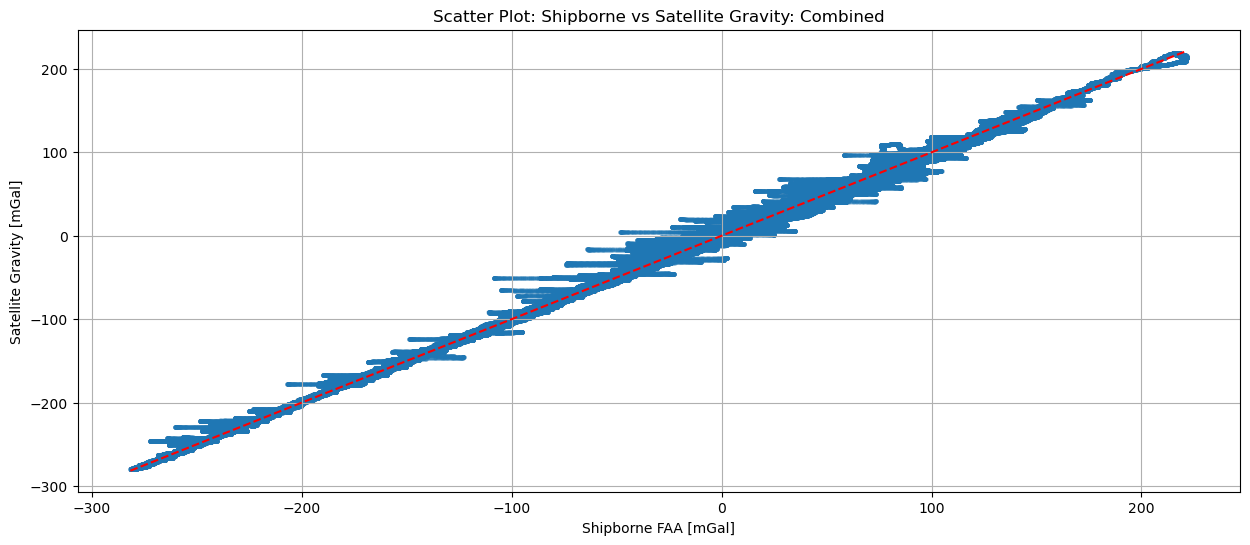

In [45]:
plt.figure(figsize=(15, 6))
plt.scatter(combined_projected['FAA'], combined_projected['satellite_gravity'], alpha=0.3, s=5)
plt.plot([combined_projected['FAA'].min(), combined_projected['FAA'].max()], [combined_projected['FAA'].min(), combined_projected['FAA'].max()], 'r--')  
plt.xlabel('Shipborne FAA [mGal]')
plt.ylabel('Satellite Gravity [mGal]')
plt.title('Scatter Plot: Shipborne vs Satellite Gravity: Combined')
plt.grid(True)
plt.show()

C:\Users\Inni\AppData\Local\Temp\ipykernel_19096\3253185696.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = garanti_projected.groupby(['x_bin', 'y_bin'])['difference'].mean().reset_index()


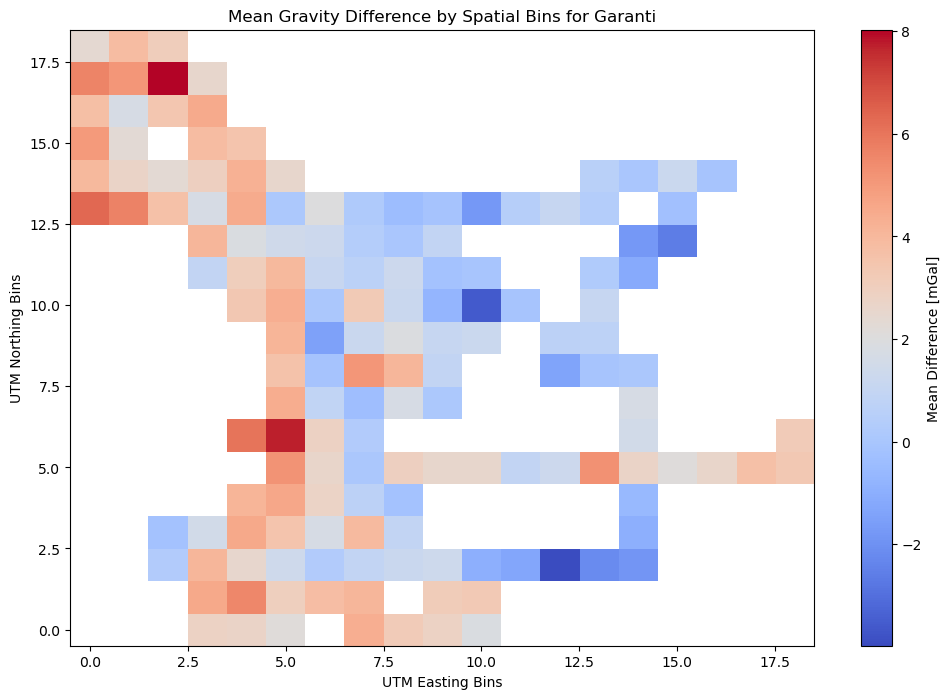

In [46]:
x_bins = np.linspace(garanti_projected['x'].min(), garanti_projected['x'].max(), 20)
y_bins = np.linspace(garanti_projected['y'].min(), garanti_projected['y'].max(), 20)

garanti_projected['x_bin'] = pd.cut(garanti_projected['x'], bins=x_bins)
garanti_projected['y_bin'] = pd.cut(garanti_projected['y'], bins=y_bins)

grouped = garanti_projected.groupby(['x_bin', 'y_bin'])['difference'].mean().reset_index()

heatmap_data = grouped.pivot(index='y_bin', columns='x_bin', values='difference')

plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar(label='Mean Difference [mGal]')
plt.title('Mean Gravity Difference by Spatial Bins for Garanti')
plt.xlabel('UTM Easting Bins')
plt.ylabel('UTM Northing Bins')
plt.show()


C:\Users\Inni\AppData\Local\Temp\ipykernel_19096\1382606280.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = antithesis_projected.groupby(['x_bin', 'y_bin'])['difference'].mean().reset_index()


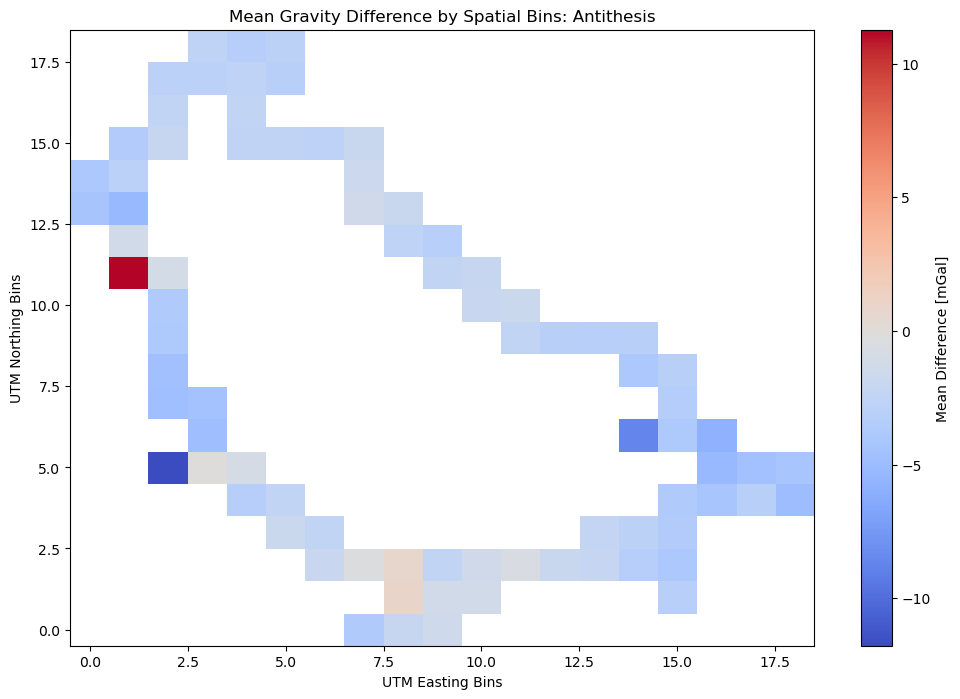

In [47]:
x_bins = np.linspace(antithesis_projected['x'].min(), antithesis_projected['x'].max(), 20)
y_bins = np.linspace(antithesis_projected['y'].min(), antithesis_projected['y'].max(), 20)

antithesis_projected['x_bin'] = pd.cut(antithesis_projected['x'], bins=x_bins)
antithesis_projected['y_bin'] = pd.cut(antithesis_projected['y'], bins=y_bins)

grouped = antithesis_projected.groupby(['x_bin', 'y_bin'])['difference'].mean().reset_index()

heatmap_data = grouped.pivot(index='y_bin', columns='x_bin', values='difference')

plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar(label='Mean Difference [mGal]')
plt.title('Mean Gravity Difference by Spatial Bins: Antithesis')
plt.xlabel('UTM Easting Bins')
plt.ylabel('UTM Northing Bins')
plt.show()

C:\Users\Inni\AppData\Local\Temp\ipykernel_19096\2233502163.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = combined_projected.groupby(['x_bin', 'y_bin'])['difference'].mean().reset_index()


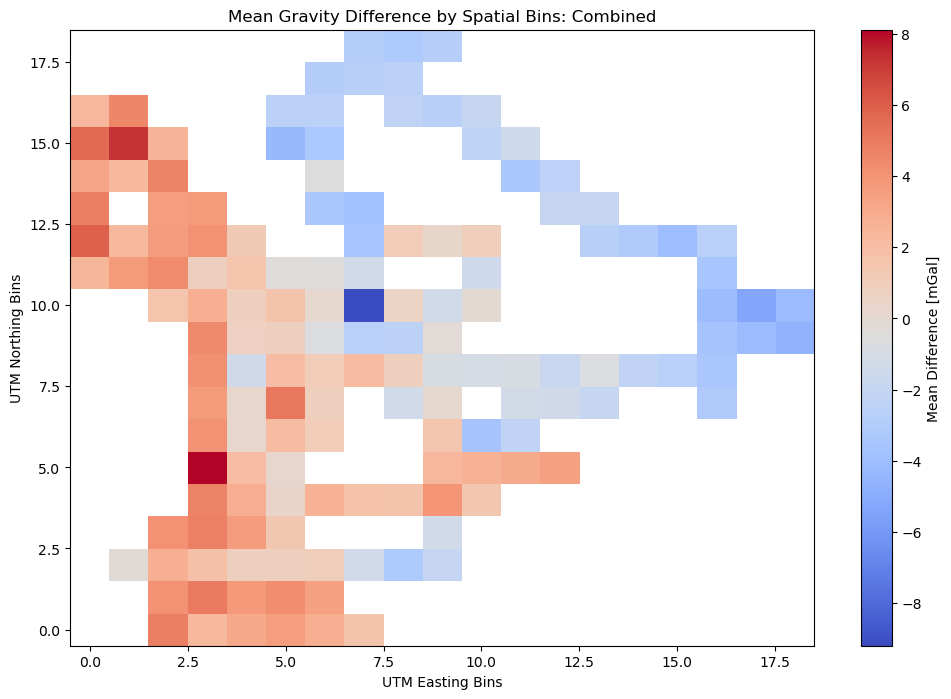

In [48]:
x_bins = np.linspace(combined_projected['x'].min(), combined_projected['x'].max(), 20)
y_bins = np.linspace(combined_projected['y'].min(), combined_projected['y'].max(), 20)

combined_projected['x_bin'] = pd.cut(combined_projected['x'], bins=x_bins)
combined_projected['y_bin'] = pd.cut(combined_projected['y'], bins=y_bins)

grouped = combined_projected.groupby(['x_bin', 'y_bin'])['difference'].mean().reset_index()

heatmap_data = grouped.pivot(index='y_bin', columns='x_bin', values='difference')

plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar(label='Mean Difference [mGal]')
plt.title('Mean Gravity Difference by Spatial Bins: Combined')
plt.xlabel('UTM Easting Bins')
plt.ylabel('UTM Northing Bins')
plt.show()

In [49]:
rmse_g = np.sqrt(mean_squared_error(garanti_projected['FAA'], garanti_projected['satellite_gravity']))
mae_g = mean_absolute_error(garanti_projected['FAA'], garanti_projected['satellite_gravity'])
corr_g = garanti_projected['FAA'].corr(garanti_projected['satellite_gravity'])

rmse_a = np.sqrt(mean_squared_error(antithesis_projected['FAA'], antithesis_projected['satellite_gravity']))
mae_a = mean_absolute_error(antithesis_projected['FAA'], antithesis_projected['satellite_gravity'])
corr_a = antithesis_projected['FAA'].corr(antithesis_projected['satellite_gravity'])

rmse_c = np.sqrt(mean_squared_error(combined_projected['FAA'], combined_projected['satellite_gravity']))
mae_c = mean_absolute_error(combined_projected['FAA'], combined_projected['satellite_gravity'])
corr_c = combined_projected['FAA'].corr(combined_projected['satellite_gravity'])

print("Garanti:")
print(f'RMSE: {rmse_g:.3f} mGal')
print(f'MAE: {mae_g:.3f} mGal')
print(f'Correlation coefficient (r): {corr_g:.3f}')
print("-----")
print("Antithesis:")
print(f'RMSE: {rmse_a:.3f} mGal')
print(f'MAE: {mae_a:.3f} mGal')
print(f'Correlation coefficient (r): {corr_a:.3f}')
print("-----")
print("Combined:")
print(f'RMSE: {rmse_c:.3f} mGal')
print(f'MAE: {mae_c:.3f} mGal')
print(f'Correlation coefficient (r): {corr_c:.3f}')


Garanti:
RMSE: 4.210 mGal
MAE: 3.032 mGal
Correlation coefficient (r): 0.998
-----
Antithesis:
RMSE: 5.099 mGal
MAE: 3.882 mGal
Correlation coefficient (r): 1.000
-----
Combined:
RMSE: 4.444 mGal
MAE: 3.240 mGal
Correlation coefficient (r): 0.998


In [50]:
threshold_g = 3 * garanti_projected['difference'].std()
outliers_g = garanti_projected[(garanti_projected['difference'] > threshold_g) | (garanti_projected['difference'] < -threshold_g)]

threshold_a = 3 * antithesis_projected['difference'].std()
outliers_a = antithesis_projected[(antithesis_projected['difference'] > threshold_a) | (antithesis_projected['difference'] < -threshold_a)]

threshold_c = 3 * combined_projected['difference'].std()
outliers_c = combined_projected[(combined_projected['difference'] > threshold_c) | (combined_projected['difference'] < -threshold_c)]

print("Garanti:")
print(f'Number of outliers: {len(outliers_g)}')
print(outliers_g[['x', 'y', 'FAA', 'satellite_gravity', 'difference']].sort_values(by='difference').head())
print("----")
print("Antithesis:")
print(f'Number of outliers: {len(outliers_a)}')
print(outliers_a[['x', 'y', 'FAA', 'satellite_gravity', 'difference']].sort_values(by='difference').head())
print("----")
print("Combined:")
print(f'Number of outliers: {len(outliers_c)}')
print(outliers_c[['x', 'y', 'FAA', 'satellite_gravity', 'difference']].sort_values(by='difference').head())


Garanti:
Number of outliers: 92568
                    x             y     FAA  satellite_gravity  difference
590313  553354.038942  1.494295e+06 -108.64         -50.187009  -58.452991
590312  553352.844114  1.494297e+06 -108.63         -50.185983  -58.444017
590314  553355.125777  1.494292e+06 -108.62         -50.188121  -58.431879
590311  553351.540624  1.494299e+06 -108.60         -50.184852  -58.415148
590315  553356.212835  1.494290e+06 -108.57         -50.189296  -58.380704
----
Antithesis:
Number of outliers: 121516
                    x             y    FAA  satellite_gravity  difference
754967  980279.436212  1.757129e+06 -73.66         -32.922950  -40.737050
754966  980280.798043  1.757125e+06 -73.65         -32.922590  -40.727410
754968  980278.176987  1.757132e+06 -73.64         -32.923253  -40.716747
754969  980276.808036  1.757136e+06 -73.61         -32.923598  -40.686402
754970  980275.439085  1.757140e+06 -73.59         -32.923944  -40.666056
----
Combined:
Number of ou

### Interpolating and merging the shipborne data lines

In [51]:
ds = xr.open_dataset('grav_LA.nc')

lon_grid = ds['lon'].values
lat_grid = ds['lat'].values
sat_grav = ds['z'].values  
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

In [52]:
gdf = gpd.GeoDataFrame(combined_projected, geometry=gpd.points_from_xy(combined_projected.lon, combined_projected.lat), crs="EPSG:4326")

shipborne_data = gdf[['lat', 'lon', 'FAA']].dropna()

In [53]:
print(shipborne_data)

               lat        lon     FAA
0        16.234451 -61.537077  109.60
1        16.234451 -61.537077  109.61
2        16.234451 -61.537077  109.61
3        16.234451 -61.537077  109.61
4        16.234451 -61.537077  109.62
...            ...        ...     ...
5018002  16.028459 -61.191997   82.99
5018003  16.028472 -61.192020   82.96
5018004  16.028485 -61.192041   82.93
5018005  16.028498 -61.192063   82.90
5018006  16.028511 -61.192087   82.87

[5018007 rows x 3 columns]


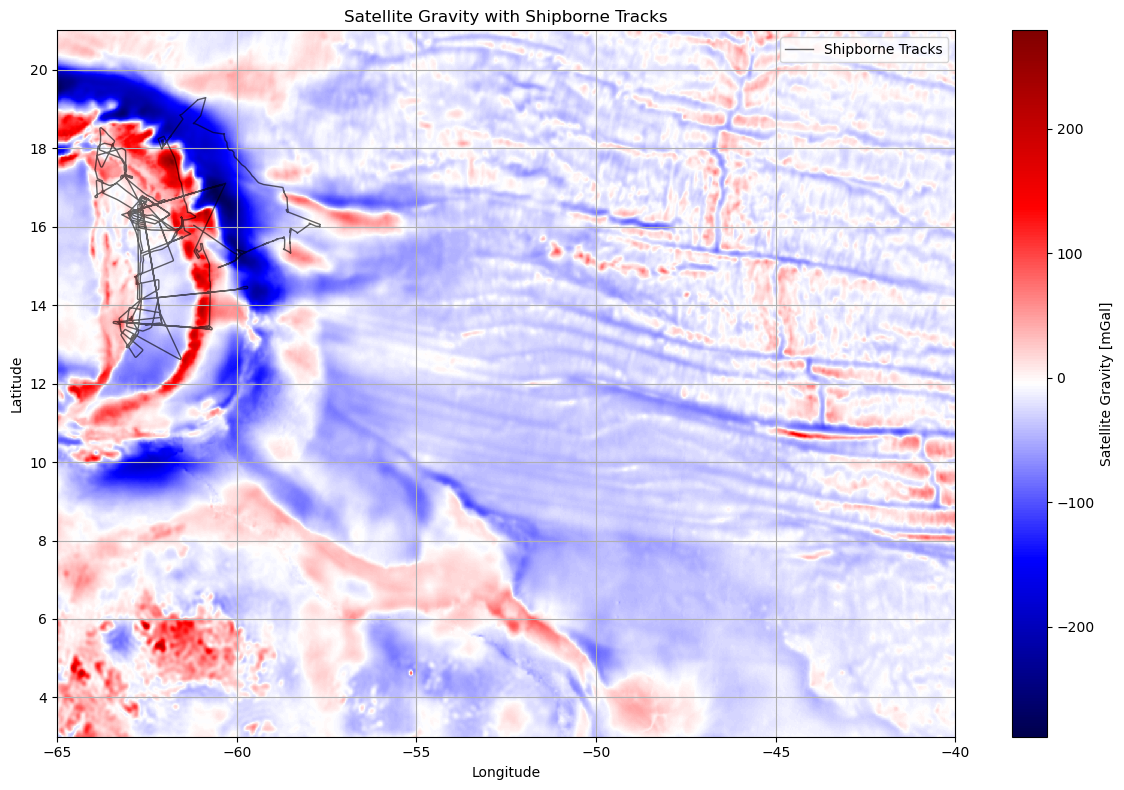

In [54]:
plt.figure(figsize=(12, 8))
plt.pcolormesh(lon_mesh, lat_mesh, sat_grav, shading='auto', cmap='seismic')
plt.colorbar(label='Satellite Gravity [mGal]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Satellite Gravity with Shipborne Tracks')

plt.plot(gdf['lon'], gdf['lat'], color='black', linewidth=1.0, alpha=0.6, label='Shipborne Tracks')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
ds_sat = xr.open_dataset("grav_LA.nc")

sat_grav = ds_sat['z']

ds_ship = xr.Dataset({
    "shipborne_FAA": (["point"], combined_projected['FAA'].values),
    "lat": (["point"], combined_projected['lat'].values),
    "lon": (["point"], combined_projected['lon'].values)
})

ds_ship_renamed = ds_ship.rename({
    "lat": "lat_point",
    "lon": "lon_point"
})

combined_nc = xr.merge([ds_sat, ds_ship_renamed])
combined_nc.to_netcdf("merged_gravity_data.nc")
print("Saved merged NetCDF file: merged_gravity_data.nc")

Saved merged NetCDF file: merged_gravity_data.nc


In [56]:
# df = ds.to_dataframe().reset_index()

# df.to_csv("", index=False)

<IPython.core.display.Javascript object>


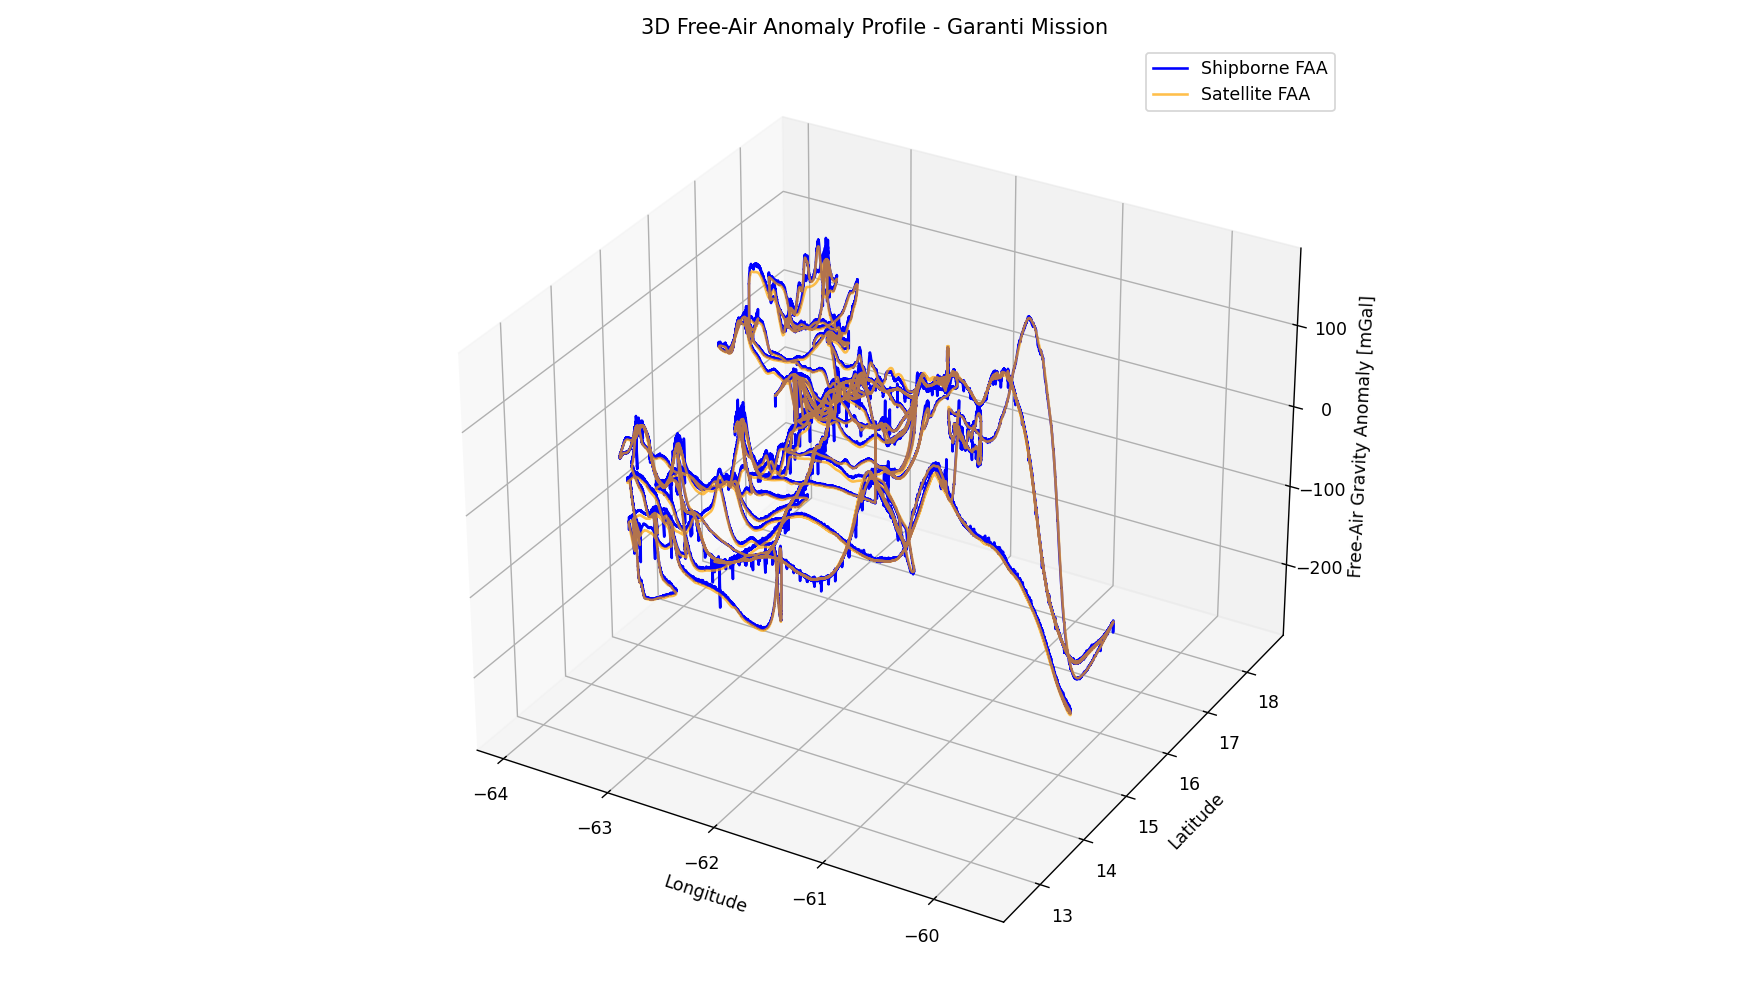

In [72]:
# %matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

garanti_data = combined_projected[combined_projected['mission'] == 'Garanti'].copy()
garanti_data = garanti_data.dropna(subset=['FAA', 'satellite_gravity'])

lon = garanti_data['lon'].values
lat = garanti_data['lat'].values
faa = garanti_data['FAA'].values
sat = garanti_data['satellite_gravity'].values

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(lon, lat, faa, color='blue', label='Shipborne FAA')
ax.plot(lon, lat, sat, color='orange', label='Satellite FAA', alpha=0.7)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Free-Air Gravity Anomaly [mGal]')
ax.set_title('3D Free-Air Anomaly Profile - Garanti Mission')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


## Simple Bouguer Anomaly

In [57]:
G = 6.674e-11  # m³/kg·s
rho_terrain = 2670  # kg/m³
rho_water = 1670    # kg/m³
g_to_mgal = 1e5     # m/s² to mGal

h = merged_grav['elevation']

rho = xr.where(h > 0, rho_terrain, rho_water)

bouguer_corr = 2 * np.pi * G * rho * h * g_to_mgal

bouguer_anomaly = merged_grav['gravity'] - bouguer_corr

merged_grav['bouguer_anomaly'] = bouguer_anomaly

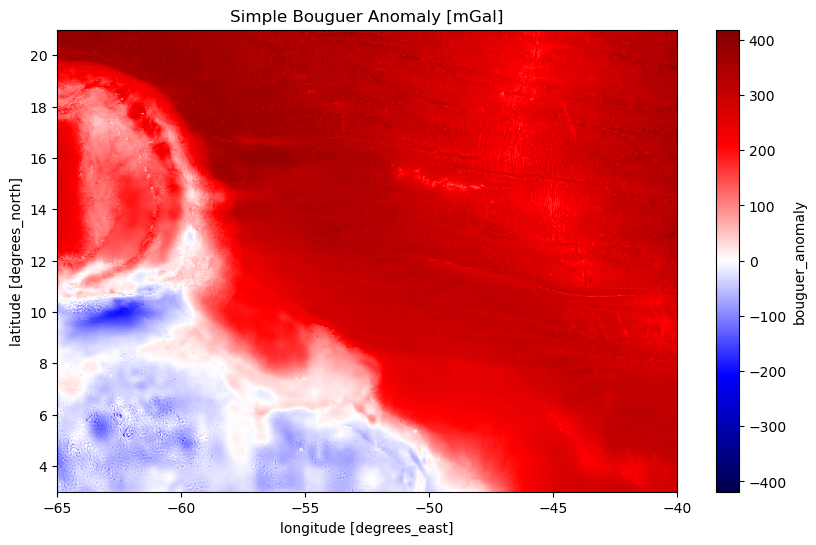

In [58]:
merged_grav['bouguer_anomaly'].plot(cmap='seismic', figsize=(10, 6))
plt.title("Simple Bouguer Anomaly [mGal]")
plt.show()